In [62]:
import matplotlib.pyplot as plt
import torch
import os
from model.datamarts.ImageDatamart import ImageDatamart
from torch import nn
from torchinfo  import summary
from torch import optim


In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [64]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BatchSize = 10
Epochs = 30
ImageSize = (50, 50)
DatamartDir = "datamart"
ModelDir = 'models/'

{'Glioma': 1426, 'Meningioma': 708, 'Pituitary tumor': 930}
['Glioma', 'Meningioma', 'Pituitary tumor']


<BarContainer object of 3 artists>

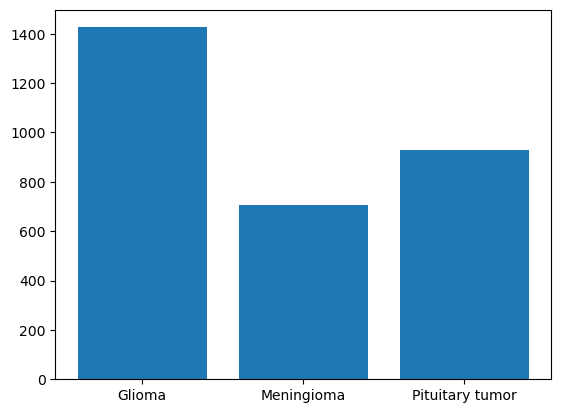

In [65]:
datamart = ImageDatamart(DatamartDir)

print(datamart.data_per_category())
print(datamart.categories())
plt.bar(datamart.data_per_category().keys(), datamart.data_per_category().values())

In [66]:

from model.dataframes.ImageDataframe import ImageDataframe

dataframe = ImageDataframe(datamart)
print(dataframe.get().keys())
print(len(list(dataframe.get().values())[0]), len(list(dataframe.get().values())[1]))

dict_keys(['Input', 'Output'])
3064 3064


In [67]:
dataframe.load_images()

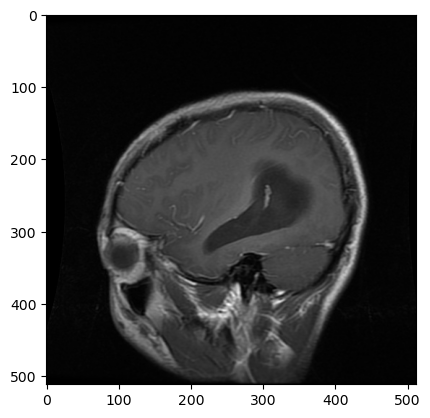

In [68]:
plt.imshow(dataframe.get()["Input"][100].content())

In [69]:
from model.mappers.ResizeImageMapper import ResizeImageMapper

resizer = ResizeImageMapper(ImageSize)
resizer.apply(dataframe, column_name="Input", output_column_name="Resized Input")

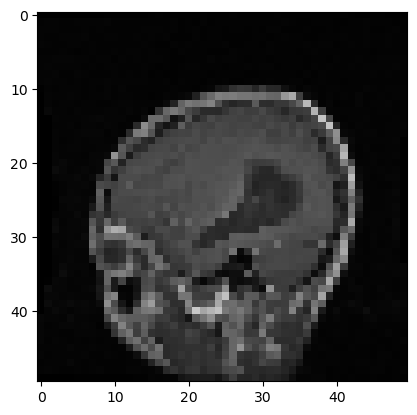

In [70]:
plt.imshow(dataframe.get()["Resized Input"][100].content())

In [71]:
from model.mappers.OneHotMapper import OneHotMapper

OneHotMapper().apply(dataframe, "Output")
dataframe.column_names()

['Input', 'Output', 'Resized Input', 'Meningioma', 'Glioma', 'Pituitary tumor']

In [72]:
print(sum(dataframe.get()["Glioma"]), sum(dataframe.get()["Meningioma"]), sum(dataframe.get()["Pituitary tumor"]))

1426 708 930


In [73]:
dataset = dataframe.to_dataset("Resized Input", ['Pituitary tumor', 'Meningioma', 'Glioma'], BatchSize)
dataset.shuffle()


In [74]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(ImageSize[0]*ImageSize[1]*3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = FullyConnected().to(device)



In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer, losses, accuracy):
    size = len(dataset)

    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        X, y = X.to(torch.float32), y.to(torch.float32)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += sum([pred[i].tolist() == y[i].tolist() for i in range(len(pred))]) / BatchSize

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            train_acc = 100*correct / size
            losses.append(loss.item())
            print(f"Accuracy: {train_acc:>0.1f}%, Avg loss: {loss.item():>8f} [{current:>5d}/{size:>5d}]")

    train_acc = 100*correct/size
    accuracy.append(train_acc)


# función de test
def test(dataloader, model, loss_fn, losses, accuracy):
    size = len(dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X, y = X.to(torch.float32), y.to(torch.float32)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += sum([pred[i].tolist() == y[i].tolist() for i in range(len(pred))]) / BatchSize
    test_loss /= num_batches
    test_acc = 100*correct/size
    losses.append(test_loss)
    accuracy.append(test_acc)
    print(f"Test Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [76]:
# bucle de entranamiento
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(Epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataset, model, loss_fn, optimizer, train_loss, train_acc)
    test(dataset, model, loss_fn, test_loss, test_acc)

print("Done!")

# torch.save(model.state_dict(), ModelDir+"model_ff.pth")
# print("Model saved model_ff.pth")


Epoch 1
-------------------------------
Accuracy: 0.0%, Avg loss: 1.224154 [   10/  307]
Accuracy: 14.0%, Avg loss: 0.551445 [ 1010/  307]
Accuracy: 30.6%, Avg loss: 1.551445 [ 2010/  307]
Accuracy: 45.5%, Avg loss: 0.551445 [ 3010/  307]
Test Error: 
 Accuracy: 46.4%, Avg loss: 1.086950 

Epoch 2
-------------------------------
Accuracy: 0.3%, Avg loss: 0.551445 [   10/  307]
Accuracy: 14.3%, Avg loss: 0.551445 [ 1010/  307]
Accuracy: 30.9%, Avg loss: 1.551445 [ 2010/  307]
Accuracy: 45.8%, Avg loss: 0.551445 [ 3010/  307]
Test Error: 
 Accuracy: 46.4%, Avg loss: 1.086950 

Epoch 3
-------------------------------
Accuracy: 0.3%, Avg loss: 0.551445 [   10/  307]
Accuracy: 14.3%, Avg loss: 0.551445 [ 1010/  307]
Accuracy: 30.9%, Avg loss: 1.551445 [ 2010/  307]
Accuracy: 45.8%, Avg loss: 0.551445 [ 3010/  307]
Test Error: 
 Accuracy: 46.4%, Avg loss: 1.086950 

Epoch 4
-------------------------------
Accuracy: 0.3%, Avg loss: 0.551445 [   10/  307]
Accuracy: 14.3%, Avg loss: 0.551445 [ 

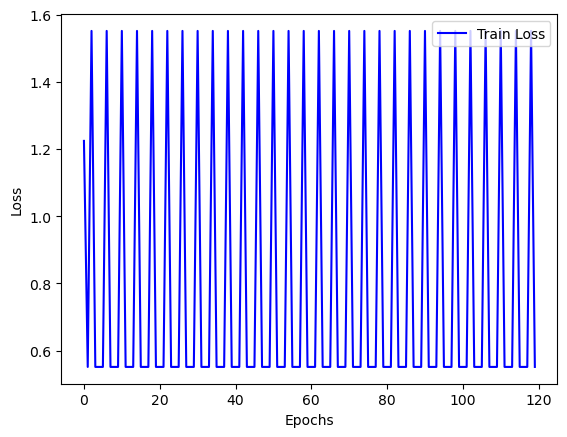

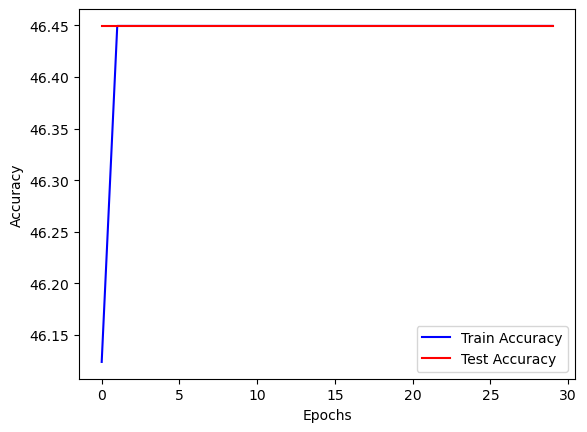

In [77]:
import matplotlib.pyplot as plt

def draw_graphics(train_loss, train_acc, test_acc):

    # Dibujamos las gráficas
    x = range(len(train_loss))
    plt.figure()
    plt.plot(x,train_loss, color='blue')
    plt.legend(['Train Loss'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('train_loss.svg')

    plt.figure()
    plt.plot(train_acc, color='blue')
    plt.plot(test_acc, color='red')
    plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('Accuracy.svg')

draw_graphics(train_loss, train_acc, test_acc)